## 先读入Align后的MALDI.h5ad文件，然后生成polygon

In [1]:
import scanpy as sc
from shapely import Polygon
import geopandas as gpd
import numpy as np
from spatialdata import read_zarr
import pandas as pd
from scipy.sparse import csr_matrix

/home/duan/miniconda3/envs/sopa/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/home/duan/miniconda3/envs/sopa/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [2]:
adata_m = sc.read_h5ad("/media/duan/sda2/MALDI/Data/20251014_5FAD/MALDI/9AA_A4_uMAIA_aligned.h5ad")
adata_m

AnnData object with n_obs × n_vars = 63446 × 1000
    obs: 'Scanned', 'x_raw', 'y_raw', 'x_scaled', 'y_scaled', 'x_scaled_aligned', 'y_scaled_aligned'
    uns: 'img_shape'
    obsm: 'spatial', 'spatial_aligned'

In [3]:
polygon_list = []

for _,row in adata_m.obs.iterrows():
    
    TopLeft_x = row['x_scaled_aligned']
    TopLeft_y = row['y_scaled_aligned']
    
    arr = np.array([[TopLeft_x, TopLeft_y], [TopLeft_x + 20, TopLeft_y], [TopLeft_x + 20, TopLeft_y + 20], [TopLeft_x, TopLeft_y + 20], [TopLeft_x, TopLeft_y]])
    polygon_list.append(Polygon(arr))

In [4]:
MALDI_gpd = gpd.GeoDataFrame(geometry=polygon_list)
MALDI_gpd.index = MALDI_gpd.index.astype(str)
MALDI_gpd

,geometry
0,"POLYGON ((2542.234 6.612, 2562.234 6.612, 2562..."
1,"POLYGON ((2603.512 6.894, 2623.512 6.894, 2623..."
2,"POLYGON ((2664.79 7.177, 2684.79 7.177, 2684.7..."
3,"POLYGON ((2726.067 7.459, 2746.067 7.459, 2746..."
4,"POLYGON ((2787.345 7.741, 2807.345 7.741, 2807..."
...,...
63441,"POLYGON ((4360.705 18507.546, 4380.705 18507.5..."
63442,"POLYGON ((4422.016 18507.804, 4442.016 18507.8..."
63443,"POLYGON ((4483.326 18508.061, 4503.326 18508.0..."
63444,"POLYGON ((4544.637 18508.319, 4564.637 18508.3..."


In [5]:
adata = sc.read_h5ad("/media/duan/sda2/MALDI/Data/20251014_5FAD/OpenFISH/9AA_5m_A4_annotated.h5ad")
adata.obs['Sample'].unique()

['9AA_5M_20um_8um_A4']
Categories (1, object): ['9AA_5M_20um_8um_A4']

In [6]:
sdata = read_zarr("OpenFISH/A4/raw_sdata.zarr/")

version mismatch: detected: RasterFormatV02, requested: FormatV04
/home/duan/miniconda3/envs/sopa/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [7]:
st_polygon = sdata.shapes['cell_boundaries'].copy()
st_polygon.index = st_polygon.index.astype(str)
st_polygon

,geometry
0,"POLYGON ((2434.429 155.925, 2433.484 160.604, ..."
1,"POLYGON ((2602.568 132.434, 2602.195 132.457, ..."
2,"POLYGON ((2673.568 135.434, 2673.29 135.446, 2..."
3,"POLYGON ((2637.393 155.831, 2609.434 209.151, ..."
4,"POLYGON ((2571.917 155.622, 2571.744 155.694, ..."
...,...
45502,"POLYGON ((3194.968 18303.782, 3195.005 18304.0..."
45503,"POLYGON ((2689.192 18281.423, 2688.875 18281.4..."
45504,"POLYGON ((2929.268 18281.46, 2915.466 18287.69..."
45505,"POLYGON ((2655.648 18292.28, 2655.357 18292.28..."


In [8]:
OpenFISH_gpd = st_polygon.loc[adata.obs_names, :].copy()
OpenFISH_gpd

,geometry
0,"POLYGON ((2434.429 155.925, 2433.484 160.604, ..."
1,"POLYGON ((2602.568 132.434, 2602.195 132.457, ..."
2,"POLYGON ((2673.568 135.434, 2673.29 135.446, 2..."
3,"POLYGON ((2637.393 155.831, 2609.434 209.151, ..."
4,"POLYGON ((2571.917 155.622, 2571.744 155.694, ..."
...,...
45500,"POLYGON ((3000.424 18272.837, 2997.538 18275.7..."
45501,"POLYGON ((3157.574 18273.434, 3157.245 18273.4..."
45502,"POLYGON ((3194.968 18303.782, 3195.005 18304.0..."
45504,"POLYGON ((2929.268 18281.46, 2915.466 18287.69..."


In [9]:
intersection = gpd.sjoin(OpenFISH_gpd, MALDI_gpd, how='inner', predicate='intersects', lsuffix='st', rsuffix='sm')
intersection

,geometry,index_sm
0,"POLYGON ((2434.429 155.925, 2433.484 160.604, ...",43
0,"POLYGON ((2434.429 155.925, 2433.484 160.604, ...",72
1,"POLYGON ((2602.568 132.434, 2602.195 132.457, ...",45
1,"POLYGON ((2602.568 132.434, 2602.195 132.457, ...",74
2,"POLYGON ((2673.568 135.434, 2673.29 135.446, 2...",46
...,...,...
45501,"POLYGON ((3157.574 18273.434, 3157.245 18273.4...",63229
45502,"POLYGON ((3194.968 18303.782, 3195.005 18304.0...",63230
45502,"POLYGON ((3194.968 18303.782, 3195.005 18304.0...",63231
45504,"POLYGON ((2929.268 18281.46, 2915.466 18287.69...",63226


* 首先去掉没有任何相交的MALDI格子
* 如果一个格子和细胞相交，该相交部分至少大于0.1，再做考虑
* 如果一个细胞和一个格子相交，如果该相交Sampling Specificity ratio (main sampling area / total sampling area) > 0.8 and Sampling Area > 0.3. 则保留该细胞
* 如果一个细胞和多个格子相交，保留Sampling Specificity ratio > 0.8的相交，留下来的相交的总和 Sampling Area > 0.3. 则保留该细胞
* 还是得处理一下两个细胞是相同细胞类型的情况, 如果相交的两个细胞属于同一个leiden类，则可以无视Sampling Specificity ratio

### intersection的index是st的细胞，是排好序的，index_right是sm的ablation marker index

In [10]:
intersection['index_st'] = intersection.index
intersection

,geometry,index_sm,index_st
0,"POLYGON ((2434.429 155.925, 2433.484 160.604, ...",43,0
0,"POLYGON ((2434.429 155.925, 2433.484 160.604, ...",72,0
1,"POLYGON ((2602.568 132.434, 2602.195 132.457, ...",45,1
1,"POLYGON ((2602.568 132.434, 2602.195 132.457, ...",74,1
2,"POLYGON ((2673.568 135.434, 2673.29 135.446, 2...",46,2
...,...,...,...
45501,"POLYGON ((3157.574 18273.434, 3157.245 18273.4...",63229,45501
45502,"POLYGON ((3194.968 18303.782, 3195.005 18304.0...",63230,45502
45502,"POLYGON ((3194.968 18303.782, 3195.005 18304.0...",63231,45502
45504,"POLYGON ((2929.268 18281.46, 2915.466 18287.69...",63226,45504


In [11]:
intersection_st = intersection.set_index('index_st', drop = True)
intersection_st.index

Index(['0', '0', '1', '1', '2', '3', '4', '4', '6', '7',
       ...
       '45497', '45498', '45499', '45499', '45500', '45501', '45502', '45502',
       '45504', '45505'],
      dtype='object', name='index_st', length=43819)

In [12]:
intersection_sm = intersection.set_index('index_sm', drop = True)
intersection_sm.index

Index(['43', '72', '45', '74', '46', '74', '74', '73', '76', '69',
       ...
       '63234', '63220', '63149', '63222', '63227', '63229', '63230', '63231',
       '63226', '63221'],
      dtype='object', name='index_sm', length=43819)

In [13]:
intersection_st['cell_type'] = adata.obs.loc[intersection_st.index.to_numpy(), 'cell_type']
intersection_st

,geometry,index_sm,cell_type
index_st,,,
0,"POLYGON ((2434.429 155.925, 2433.484 160.604, ...",43,Inh Lamp5
0,"POLYGON ((2434.429 155.925, 2433.484 160.604, ...",72,Inh Lamp5
1,"POLYGON ((2602.568 132.434, 2602.195 132.457, ...",45,Mural
1,"POLYGON ((2602.568 132.434, 2602.195 132.457, ...",74,Mural
2,"POLYGON ((2673.568 135.434, 2673.29 135.446, 2...",46,Mural
...,...,...,...
45501,"POLYGON ((3157.574 18273.434, 3157.245 18273.4...",63229,Ext LH-HY-MEA
45502,"POLYGON ((3194.968 18303.782, 3195.005 18304.0...",63230,Fibro
45502,"POLYGON ((3194.968 18303.782, 3195.005 18304.0...",63231,Fibro


## 直接遍历每一个细胞

In [14]:
from tqdm import tqdm

In [15]:
kept_st_sm_pairs = []

for st_idx in tqdm(intersection_st.index.unique()):
    tmp_ct= intersection_st.loc[[st_idx],:]
    cell_segmentation = OpenFISH_gpd.loc[st_idx, 'geometry']

    sampling_area = 0
    kept_sm_idxs = []
    for sm_idx in tmp_ct['index_sm'].values:
        ablation_marker = MALDI_gpd.loc[sm_idx, 'geometry']

        main_sampling_area = ablation_marker.intersection(cell_segmentation).area

        if main_sampling_area > 0.1 * ablation_marker.area:
            # 首先看Sampling Specificity ratio
            total_sampling_area = 0
            tmp_sm = intersection_sm.loc[[sm_idx], :]
            
            for st_idx2 in tmp_sm['index_st'].values:
                cell_segmentation2 = OpenFISH_gpd.loc[st_idx2, 'geometry']
                total_sampling_area += ablation_marker.intersection(cell_segmentation2).area
    
            # 再看Sampling Area
            if main_sampling_area / total_sampling_area >= 0.8 or len(intersection_st.loc[tmp_sm['index_st'].values, 'cell_type'].unique()) == 1: # 同一种细胞类型或者只和一个细胞相交
                
                sampling_area += main_sampling_area
                # 记录保留下来的MALDI格子
                kept_sm_idxs.append(sm_idx)
        
    if sampling_area >= 0.3 * ablation_marker.area:     
        # 此时留下来的细胞就是符合要求的细胞
        for sm_idx in kept_sm_idxs:
            kept_st_sm_pairs.append((st_idx, sm_idx))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36334/36334 [01:08<00:00, 533.78it/s]


In [16]:
kept_st_sm_pairs[0:5]

[('1', '45'), ('1', '74'), ('2', '46'), ('3', '74'), ('4', '73')]

In [17]:
intersection= intersection.set_index(['index_st', 'index_sm'], drop = False)

In [18]:
intersection = intersection.loc[kept_st_sm_pairs, :].copy()

In [19]:
intersection

geometry index_sm  \
index_st index_sm                                                               
1        45        POLYGON ((2602.568 132.434, 2602.195 132.457, ...       45   
         74        POLYGON ((2602.568 132.434, 2602.195 132.457, ...       74   
2        46        POLYGON ((2673.568 135.434, 2673.29 135.446, 2...       46   
3        74        POLYGON ((2637.393 155.831, 2609.434 209.151, ...       74   
4        73        POLYGON ((2571.917 155.622, 2571.744 155.694, ...       73   
...                                                              ...      ...   
45499    63222     POLYGON ((2710.621 18270.38, 2707.99 18271.438...    63222   
45501    63229     POLYGON ((3157.574 18273.434, 3157.245 18273.4...    63229   
45502    63230     POLYGON ((3194.968 18303.782, 3195.005 18304.0...    63230   
         63231     POLYGON ((3194.968 18303.782, 3195.005 18304.0...    63231   
45504    63226     POLYGON ((2929.268 18281.46, 2915.466 18287.69...    63226   

                  index_st  
index_st index_sm           
1        45              1  
         74              1  
2        46              2  
3        74              3  
4        73              4  
...                    ...  
45499    63222       45499  
45501    63229       45501  
45502    63230       45502  
         63231       45502  
45504    63226       45504  

[17366 rows x 3 columns]

In [20]:
len(intersection['index_st'].unique())

16169

In [21]:
def process_row(row):

    st_cell = OpenFISH_gpd.loc[row['index_st'],'geometry']
    sm_spot = MALDI_gpd.loc[row['index_sm'],'geometry']
    
    cell_area = st_cell.area
    ablation_area = sm_spot.area
    sampling_area = st_cell.intersection(sm_spot).area
        
    total_sampling_area = 0
    tmp_sm = intersection_sm.loc[[row['index_sm']], :]
    for st_idx2 in tmp_sm['index_st'].values:
        cell_segmentation2 = OpenFISH_gpd.loc[st_idx2, 'geometry']
        total_sampling_area += sm_spot.intersection(cell_segmentation2).area

    sampling_specificity = sampling_area / total_sampling_area

    if sampling_specificity< 0.8:
        sampling_specificity = 1.0

    return cell_area, ablation_area, sampling_area, sampling_specificity

In [22]:
intersection[['cell_areas', 'ablation_areas', 'sampling_areas', 'sampling_specificities']] = intersection.apply(process_row, axis=1, result_type='expand')

In [23]:
intersection

geometry index_sm  \
index_st index_sm                                                               
1        45        POLYGON ((2602.568 132.434, 2602.195 132.457, ...       45   
         74        POLYGON ((2602.568 132.434, 2602.195 132.457, ...       74   
2        46        POLYGON ((2673.568 135.434, 2673.29 135.446, 2...       46   
3        74        POLYGON ((2637.393 155.831, 2609.434 209.151, ...       74   
4        73        POLYGON ((2571.917 155.622, 2571.744 155.694, ...       73   
...                                                              ...      ...   
45499    63222     POLYGON ((2710.621 18270.38, 2707.99 18271.438...    63222   
45501    63229     POLYGON ((3157.574 18273.434, 3157.245 18273.4...    63229   
45502    63230     POLYGON ((3194.968 18303.782, 3195.005 18304.0...    63230   
         63231     POLYGON ((3194.968 18303.782, 3195.005 18304.0...    63231   
45504    63226     POLYGON ((2929.268 18281.46, 2915.466 18287.69...    63226   

                  index_st   cell_areas  ablation_areas  sampling_areas  \
index_st index_sm                                                         
1        45              1  2929.402346           400.0      310.693085   
         74              1  2929.402346           400.0      192.495568   
2        46              2  3301.497547           400.0      272.495039   
3        74              3  2560.172594           400.0      168.830717   
4        73              4  3149.304659           400.0      293.089720   
...                    ...          ...             ...             ...   
45499    63222       45499  2138.032171           400.0      178.125793   
45501    63229       45501  2830.574258           400.0      177.963164   
45502    63230       45502  3037.638113           400.0      109.625908   
         63231       45502  3037.638113           400.0      137.677460   
45504    63226       45504  1976.427435           400.0      186.748587   

                   sampling_specificities  
index_st index_sm                          
1        45                           1.0  
         74                           1.0  
2        46                           1.0  
3        74                           1.0  
4        73                           1.0  
...                                   ...  
45499    63222                        1.0  
45501    63229                        1.0  
45502    63230                        1.0  
         63231                        1.0  
45504    63226                        1.0  

[17366 rows x 7 columns]

In [24]:
adata_m

AnnData object with n_obs × n_vars = 63446 × 1000
    obs: 'Scanned', 'x_raw', 'y_raw', 'x_scaled', 'y_scaled', 'x_scaled_aligned', 'y_scaled_aligned'
    uns: 'img_shape'
    obsm: 'spatial', 'spatial_aligned'

## 先把保留下来的Ablation Marker画个图去Xenium Explorer上看看效果

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
scaler = MinMaxScaler((10000, 60000))

In [28]:
np.unique(intersection['index_sm'].astype(int).to_numpy())

array([   11,    71,    72, ..., 32396, 32397, 32398])

In [29]:
tmp = adata_m[np.unique(intersection['index_sm'].astype(int).to_numpy()),:].copy()

In [30]:
tmp.obs = tmp.obs.reset_index()

In [31]:
intensity = tmp.to_df()['283.26373'].to_numpy().reshape(-1,1)

In [32]:
intensity = np.clip(intensity, 0, np.percentile(intensity, 99))

In [33]:
intensity = scaler.fit_transform(intensity)

In [34]:
sdata

SpatialData object, with associated Zarr store: /media/duan/sda2/MALDI/Data/20251014_5FAD/OpenFISH/A6/raw_sdata.zarr
├── Images
│     └── 'fluorescence': DataArray[cyx] (4, 16788, 16778)
├── Points
│     ├── 'transcripts': DataFrame with shape: (<Delayed>, 4) (2D points)
│     └── 'transcripts_filtered': DataFrame with shape: (<Delayed>, 4) (2D points)
├── Shapes
│     ├── 'AF405_boundaries': GeoDataFrame shape: (43484, 1) (2D shapes)
│     └── 'cell_boundaries': GeoDataFrame shape: (43464, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (43464, 110)
with coordinate systems:
    ▸ 'global', with elements:
        fluorescence (Images), transcripts (Points), transcripts_filtered (Points), AF405_boundaries (Shapes), cell_boundaries (Shapes)

In [42]:
m_img = np.zeros(shape = (16788, 16778))

In [43]:
for idx ,row in tmp.obs.iterrows():
    x = int(row['x_scaled_aligned'])
    y = int(row['y_scaled_aligned'])
    
    x1 = int(max(0, x))
    x2 = int(min(16788, x + 40))
    y1 = int(max(0, y))
    y2 = int(min(16778, y + 40))
    
    if not x1 == x2 or y1 == y2:
        m_img[y1:y2, x1:x2] = intensity[int(idx)]

In [44]:
m_img = m_img.astype(np.uint16)

In [45]:
import tifffile

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x79caad7c65f0>)

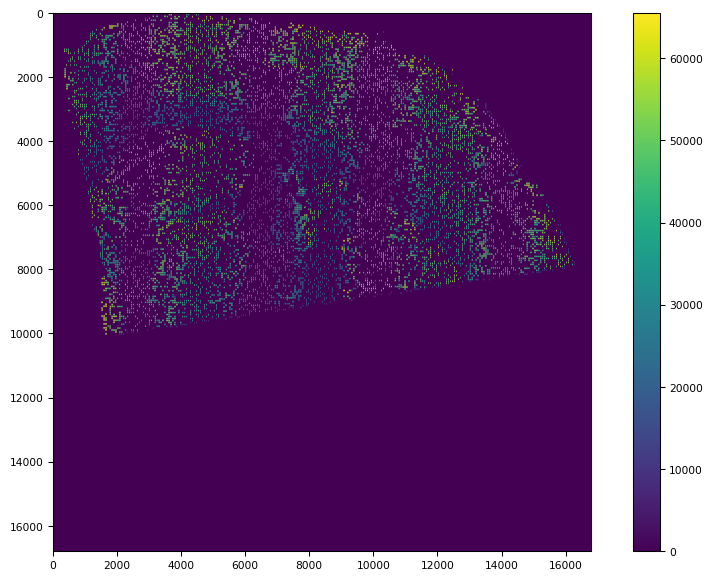

In [46]:
tifffile.imshow(m_img)

In [47]:
tifffile.imwrite("/media/duan/sda2/MALDI/Data/20251014_5FAD/Registration_A6/Aligned_283.26373.tif", m_img)

In [48]:
intersection.to_csv("/media/duan/sda2/MALDI/Data/20251014_5FAD/Registration_A6/Intersection.csv")

## Xenium上看着效果还不错，接下来把MALDI的Intensity转移到细胞中

In [25]:
adata

AnnData object with n_obs × n_vars = 41122 × 99
    obs: 'region', 'Name', 'x', 'y', 'area', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_FP', 'log1p_total_counts_FP', 'pct_counts_FP', 'log1p_area', 'Sample', 'cell_type', 'Batch'
    uns: 'Batch_colors', 'Sample_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'counts_corrected'
    obsp: 'connectivities', 'distances'

In [26]:
intersection

geometry index_sm  \
index_st index_sm                                                               
1        45        POLYGON ((2602.568 132.434, 2602.195 132.457, ...       45   
         74        POLYGON ((2602.568 132.434, 2602.195 132.457, ...       74   
2        46        POLYGON ((2673.568 135.434, 2673.29 135.446, 2...       46   
3        74        POLYGON ((2637.393 155.831, 2609.434 209.151, ...       74   
4        73        POLYGON ((2571.917 155.622, 2571.744 155.694, ...       73   
...                                                              ...      ...   
45499    63222     POLYGON ((2710.621 18270.38, 2707.99 18271.438...    63222   
45501    63229     POLYGON ((3157.574 18273.434, 3157.245 18273.4...    63229   
45502    63230     POLYGON ((3194.968 18303.782, 3195.005 18304.0...    63230   
         63231     POLYGON ((3194.968 18303.782, 3195.005 18304.0...    63231   
45504    63226     POLYGON ((2929.268 18281.46, 2915.466 18287.69...    63226   

                  index_st   cell_areas  ablation_areas  sampling_areas  \
index_st index_sm                                                         
1        45              1  2929.402346           400.0      310.693085   
         74              1  2929.402346           400.0      192.495568   
2        46              2  3301.497547           400.0      272.495039   
3        74              3  2560.172594           400.0      168.830717   
4        73              4  3149.304659           400.0      293.089720   
...                    ...          ...             ...             ...   
45499    63222       45499  2138.032171           400.0      178.125793   
45501    63229       45501  2830.574258           400.0      177.963164   
45502    63230       45502  3037.638113           400.0      109.625908   
         63231       45502  3037.638113           400.0      137.677460   
45504    63226       45504  1976.427435           400.0      186.748587   

                   sampling_specificities  
index_st index_sm                          
1        45                           1.0  
         74                           1.0  
2        46                           1.0  
3        74                           1.0  
4        73                           1.0  
...                                   ...  
45499    63222                        1.0  
45501    63229                        1.0  
45502    63230                        1.0  
         63231                        1.0  
45504    63226                        1.0  

[17366 rows x 7 columns]

In [27]:
mdf = adata_m.to_df()
mdf

m/z,295.08566,295.14077,296.05593,296.08098,296.11605,296.19788,297.00950,297.03622,297.06461,348.11150,...,553.27601,916.65131,420.12524,420.25717,421.14227,422.13926,832.50836,833.51203,834.52572,834.57248
15,3.858289,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.857162,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.382074,0.0
16,1.862660,0.0,0.0,1.583994,0.0,0.0,0.0,0.0,1.803993,0.0,...,0.0,0.0,0.0,1.613327,0.0,0.0,0.0,0.0,1.891993,0.0
17,2.406654,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.530869,0.0,...,0.0,0.0,0.0,1.863216,0.0,0.0,0.0,0.0,0.000000,0.0
18,3.902552,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.315764,0.0,...,0.0,0.0,0.0,1.438588,0.0,0.0,0.0,0.0,2.999609,0.0
19,2.454331,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.972499,0.0,...,0.0,0.0,0.0,2.077900,0.0,0.0,0.0,0.0,3.192137,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63456,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
63457,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
63458,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
63459,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [28]:
mdf = mdf.reset_index(drop = True)
mdf.index = mdf.index.astype(str)
mdf

m/z,295.08566,295.14077,296.05593,296.08098,296.11605,296.19788,297.00950,297.03622,297.06461,348.11150,...,553.27601,916.65131,420.12524,420.25717,421.14227,422.13926,832.50836,833.51203,834.52572,834.57248
0,3.858289,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.857162,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.382074,0.0
1,1.862660,0.0,0.0,1.583994,0.0,0.0,0.0,0.0,1.803993,0.0,...,0.0,0.0,0.0,1.613327,0.0,0.0,0.0,0.0,1.891993,0.0
2,2.406654,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.530869,0.0,...,0.0,0.0,0.0,1.863216,0.0,0.0,0.0,0.0,0.000000,0.0
3,3.902552,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.315764,0.0,...,0.0,0.0,0.0,1.438588,0.0,0.0,0.0,0.0,2.999609,0.0
4,2.454331,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.972499,0.0,...,0.0,0.0,0.0,2.077900,0.0,0.0,0.0,0.0,3.192137,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63441,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
63442,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
63443,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
63444,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [29]:
new_frame_list = []
total_sampling_areas = []

for st_idx in tqdm(intersection['index_st'].unique()):

    tmp_inter = intersection.loc[[st_idx],['index_sm', 'ablation_areas', 'sampling_areas', 'sampling_specificities']].copy()
    sm_idxs = tmp_inter['index_sm'].values.reshape(-1,)

    total_sampling_area = (tmp_inter['sampling_areas'] * tmp_inter['sampling_specificities']).sum()
    
    multipliers = pd.Series((tmp_inter['sampling_areas'] / tmp_inter['ablation_areas'] * tmp_inter['sampling_specificities']).values, index=sm_idxs)

    tmp = mdf.loc[sm_idxs, :].copy()
    tmp = tmp.mul(multipliers, axis=0)
    
    new_frame_list.append(tmp.sum().to_frame(name = st_idx).T)
    total_sampling_areas.append(total_sampling_area)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16169/16169 [00:38<00:00, 424.73it/s]


In [30]:
final = pd.concat(new_frame_list)
final

m/z,295.08566,295.14077,296.05593,296.08098,296.11605,296.19788,297.00950,297.03622,297.06461,348.11150,...,553.27601,916.65131,420.12524,420.25717,421.14227,422.13926,832.50836,833.51203,834.52572,834.57248
1,6.404983,3.704461,0.000000,0.000000,0.0,0.0,0.000000,13.628398,7.661331,0.000000,...,8.042052,0.0,0.000000,79.023665,0.000000,0.0,9.078842,9.996479,82.351782,0.000000
2,5.616233,0.000000,0.000000,2.576254,0.0,0.0,0.000000,2.859641,7.574186,0.000000,...,2.550491,0.0,4.044718,47.300016,0.000000,0.0,6.775547,4.663019,117.477166,0.000000
3,2.920252,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.818855,1.784599,0.000000,...,2.210469,0.0,0.000000,21.983011,0.000000,0.0,3.548918,2.514662,49.177862,0.000000
4,6.160230,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,8.346119,0.000000,...,4.305537,0.0,0.000000,51.235894,3.046996,0.0,4.636733,3.311952,137.843435,3.576908
7,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.800300,0.000000,...,2.351744,0.0,0.000000,22.674052,0.000000,0.0,2.108460,0.000000,59.053093,2.627465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,4.442814,1.428825,0.893015,1.408980,0.0,0.0,1.031929,0.000000,6.325251,0.000000,...,0.000000,0.0,0.000000,4.075990,0.668743,0.0,0.000000,0.000000,3.394830,0.000000
45499,1.708767,0.000000,0.000000,0.921248,0.0,0.0,0.000000,0.000000,2.310550,0.000000,...,0.000000,0.0,0.638930,1.032690,0.000000,0.0,0.000000,0.000000,1.560179,0.000000
45501,2.139277,0.000000,0.000000,0.000000,0.0,0.0,0.754186,0.000000,2.893462,0.000000,...,0.000000,0.0,1.037005,0.877466,0.862962,0.0,0.000000,0.000000,0.848459,0.000000
45502,1.971805,0.000000,0.369405,0.436570,0.0,0.0,0.000000,0.000000,4.193482,0.000000,...,0.000000,0.0,0.625470,0.759799,0.647253,0.0,0.000000,0.000000,1.715185,0.000000


In [31]:
adata_merged = sc.AnnData(final)

In [32]:
adata_merged.obs['total_sampling_area'] = total_sampling_areas

In [33]:
adata = adata[intersection['index_st'].unique().astype(str),:].copy()

In [34]:
len(intersection['index_sm'].unique())

16636

In [35]:
adata_merged.obs['cell_type'] = adata.obs['cell_type']
adata_merged.obsm = adata.obsm

In [36]:
adata_merged.write_h5ad("All_Aligned/9AA_A4_transferMALDI.h5ad")
adata.write_h5ad("All_Aligned/9AA_A4_transferFISH.h5ad")

## Cell type Unaware

In [61]:
adata_m = sc.read_h5ad("/media/duan/sda2/MALDI/Data/20251014_5FAD/MALDI/9AA_A6_uMAIA_aligned.h5ad")
adata_m

AnnData object with n_obs × n_vars = 32401 × 1573
    obs: 'Scanned', 'x_raw', 'y_raw', 'x_scaled', 'y_scaled', 'x_scaled_aligned', 'y_scaled_aligned'
    uns: 'img_shape'
    obsm: 'spatial', 'spatial_aligned'

In [62]:
polygon_list = []

for _,row in adata_m.obs.iterrows():
    
    TopLeft_x = row['x_scaled_aligned']
    TopLeft_y = row['y_scaled_aligned']
    
    arr = np.array([[TopLeft_x, TopLeft_y], [TopLeft_x + 40, TopLeft_y], [TopLeft_x + 40, TopLeft_y + 40], [TopLeft_x, TopLeft_y + 40], [TopLeft_x, TopLeft_y]])
    polygon_list.append(Polygon(arr))

In [63]:
MALDI_gpd = gpd.GeoDataFrame(geometry=polygon_list)
MALDI_gpd.index = MALDI_gpd.index.astype(str)
MALDI_gpd

,geometry
0,"POLYGON ((3542.351 4.006, 3582.351 4.006, 3582..."
1,"POLYGON ((3603.554 4.186, 3643.554 4.186, 3643..."
2,"POLYGON ((3664.756 4.366, 3704.756 4.366, 3704..."
3,"POLYGON ((3725.959 4.546, 3765.959 4.546, 3765..."
4,"POLYGON ((3787.162 4.726, 3827.162 4.726, 3827..."
...,...
32396,"POLYGON ((2066.563 10009.081, 2106.563 10009.0..."
32397,"POLYGON ((2127.647 10009.217, 2167.647 10009.2..."
32398,"POLYGON ((2188.73 10009.353, 2228.73 10009.353..."
32399,"POLYGON ((2249.814 10009.489, 2289.814 10009.4..."


In [64]:
adata = sc.read_h5ad("/media/duan/sda2/MALDI/Data/20251014_5FAD/OpenFISH/9AA_5m_A6_annotated.h5ad")
adata.obs['Sample'].unique()

['9AA_5M_20um_16um_A6_Ctrl', '9AA_5M_20um_16um_A6']
Categories (2, object): ['9AA_5M_20um_16um_A6', '9AA_5M_20um_16um_A6_Ctrl']

In [65]:
adata = adata[adata.obs['Sample'] == '9AA_5M_20um_16um_A6'].copy()
adata

AnnData object with n_obs × n_vars = 21272 × 99
    obs: 'region', 'Name', 'x', 'y', 'area', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_FP', 'log1p_total_counts_FP', 'pct_counts_FP', 'log1p_area', 'Sample', 'cell_type', 'Batch'
    uns: 'Batch_colors', 'Sample_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'counts_corrected'
    obsp: 'connectivities', 'distances'

In [66]:
sdata = read_zarr("OpenFISH/A6/raw_sdata.zarr/")

version mismatch: detected: RasterFormatV02, requested: FormatV04
/home/duan/miniconda3/envs/sopa/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [67]:
st_polygon = sdata.shapes['cell_boundaries'].copy()
st_polygon.index = st_polygon.index.astype(str)
st_polygon

,geometry
0,"POLYGON ((15649.939 9423.708, 15648.949 9423.7..."
1,"POLYGON ((13526.752 14817.295, 13524.817 14817..."
2,"POLYGON ((12675.041 11664.638, 12674.676 11661..."
3,"POLYGON ((11938.268 11759.427, 11937.443 11755..."
4,"POLYGON ((4015.897 14560.841, 4015.234 14561.0..."
...,...
43479,"POLYGON ((12349.856 10472.913, 12313.561 10488..."
43480,"POLYGON ((12214.753 2915.067, 12213.441 2915.1..."
43481,"POLYGON ((5691.981 572.018, 5690.659 572.091, ..."
43482,"POLYGON ((10415.829 14659.617, 10415.926 14660..."


In [68]:
OpenFISH_gpd = st_polygon.loc[adata.obs_names, :].copy()
OpenFISH_gpd

,geometry
54,"POLYGON ((6441.828 5962.01, 6440.857 5961.958,..."
78,"POLYGON ((13935.61 7866.992, 13935.335 7865.89..."
153,"POLYGON ((13750.031 7944.816, 13749.724 7944.8..."
164,"POLYGON ((3307.768 2869.022, 3305.256 2869.069..."
176,"POLYGON ((6270.833 5757.189, 6269.937 5755.079..."
...,...
43476,"POLYGON ((10920.672 1629.32, 10895.982 1642.70..."
43478,"POLYGON ((8223.479 6151.408, 8222.292 6151.516..."
43480,"POLYGON ((12214.753 2915.067, 12213.441 2915.1..."
43481,"POLYGON ((5691.981 572.018, 5690.659 572.091, ..."


In [69]:
intersection = gpd.sjoin(OpenFISH_gpd, MALDI_gpd, how='inner', predicate='intersects', lsuffix='st', rsuffix='sm')
intersection

,geometry,index_sm
54,"POLYGON ((6441.828 5962.01, 6440.857 5961.958,...",20062
54,"POLYGON ((6441.828 5962.01, 6440.857 5961.958,...",20307
78,"POLYGON ((13935.61 7866.992, 13935.335 7865.89...",27581
78,"POLYGON ((13935.61 7866.992, 13935.335 7865.89...",27827
153,"POLYGON ((13750.031 7944.816, 13749.724 7944.8...",28068
...,...,...
43480,"POLYGON ((12214.753 2915.067, 12213.441 2915.1...",8498
43480,"POLYGON ((12214.753 2915.067, 12213.441 2915.1...",8721
43481,"POLYGON ((5691.981 572.018, 5690.659 572.091, ...",1049
43483,"POLYGON ((8178.038 6792.654, 8176.915 6792.702...",23534


* 首先去掉没有任何相交的MALDI格子
* 如果一个格子和细胞相交，该相交部分至少大于0.1，再做考虑
* 如果一个细胞和一个格子相交，如果该相交Sampling Specificity ratio (main sampling area / total sampling area) > 0.8 and Sampling Area > 0.3. 则保留该细胞
* 如果一个细胞和多个格子相交，保留Sampling Specificity ratio > 0.8的相交，留下来的相交的总和 Sampling Area > 0.3. 则保留该细胞
* 还是得处理一下两个细胞是相同细胞类型的情况, 如果相交的两个细胞属于同一个leiden类，则可以无视Sampling Specificity ratio

### intersection的index是st的细胞，是排好序的，index_right是sm的ablation marker index

In [70]:
intersection['index_st'] = intersection.index
intersection

,geometry,index_sm,index_st
54,"POLYGON ((6441.828 5962.01, 6440.857 5961.958,...",20062,54
54,"POLYGON ((6441.828 5962.01, 6440.857 5961.958,...",20307,54
78,"POLYGON ((13935.61 7866.992, 13935.335 7865.89...",27581,78
78,"POLYGON ((13935.61 7866.992, 13935.335 7865.89...",27827,78
153,"POLYGON ((13750.031 7944.816, 13749.724 7944.8...",28068,153
...,...,...,...
43480,"POLYGON ((12214.753 2915.067, 12213.441 2915.1...",8498,43480
43480,"POLYGON ((12214.753 2915.067, 12213.441 2915.1...",8721,43480
43481,"POLYGON ((5691.981 572.018, 5690.659 572.091, ...",1049,43481
43483,"POLYGON ((8178.038 6792.654, 8176.915 6792.702...",23534,43483


In [71]:
intersection_st = intersection.set_index('index_st', drop = True)
intersection_st.index

Index(['54', '54', '78', '78', '153', '164', '176', '237', '241', '255',
       ...
       '43474', '43476', '43476', '43478', '43478', '43480', '43480', '43481',
       '43483', '43483'],
      dtype='object', name='index_st', length=35828)

In [72]:
intersection_sm = intersection.set_index('index_sm', drop = True)
intersection_sm.index

Index(['20062', '20307', '27581', '27827', '28068', '8576', '19327', '1959',
       '31952', '2502',
       ...
       '26956', '3994', '4195', '20827', '21073', '8498', '8721', '1049',
       '23534', '23535'],
      dtype='object', name='index_sm', length=35828)

In [73]:
intersection_st['cell_type'] = adata.obs.loc[intersection_st.index.to_numpy(), 'cell_type']
intersection_st

,geometry,index_sm,cell_type
index_st,,,
54,"POLYGON ((6441.828 5962.01, 6440.857 5961.958,...",20062,Oligo
54,"POLYGON ((6441.828 5962.01, 6440.857 5961.958,...",20307,Oligo
78,"POLYGON ((13935.61 7866.992, 13935.335 7865.89...",27581,Inh PAL-HY
78,"POLYGON ((13935.61 7866.992, 13935.335 7865.89...",27827,Inh PAL-HY
153,"POLYGON ((13750.031 7944.816, 13749.724 7944.8...",28068,Ext CLA-EPd
...,...,...,...
43480,"POLYGON ((12214.753 2915.067, 12213.441 2915.1...",8498,Ext L4/5 IT
43480,"POLYGON ((12214.753 2915.067, 12213.441 2915.1...",8721,Ext L4/5 IT
43481,"POLYGON ((5691.981 572.018, 5690.659 572.091, ...",1049,Ext L2/3 IT


## 直接遍历每一个细胞

In [74]:
from tqdm import tqdm

In [75]:
kept_st_sm_pairs = []

for st_idx in tqdm(intersection_st.index.unique()):
    tmp_ct= intersection_st.loc[[st_idx],:]
    cell_segmentation = OpenFISH_gpd.loc[st_idx, 'geometry']

    sampling_area = 0
    kept_sm_idxs = []
    for sm_idx in tmp_ct['index_sm'].values:
        ablation_marker = MALDI_gpd.loc[sm_idx, 'geometry']

        main_sampling_area = ablation_marker.intersection(cell_segmentation).area

        if main_sampling_area > 0.1 * ablation_marker.area:
            # 首先看Sampling Specificity ratio
            total_sampling_area = 0
            tmp_sm = intersection_sm.loc[[sm_idx], :]
            
            for st_idx2 in tmp_sm['index_st'].values:
                cell_segmentation2 = OpenFISH_gpd.loc[st_idx2, 'geometry']
                total_sampling_area += ablation_marker.intersection(cell_segmentation2).area
    
            # 再看Sampling Area
            if main_sampling_area / total_sampling_area >= 0.8: # 同一种细胞类型或者只和一个细胞相交
                
                sampling_area += main_sampling_area
                # 记录保留下来的MALDI格子
                kept_sm_idxs.append(sm_idx)
        
    if sampling_area >= 0.3 * ablation_marker.area:     
        # 此时留下来的细胞就是符合要求的细胞
        for sm_idx in kept_sm_idxs:
            kept_st_sm_pairs.append((st_idx, sm_idx))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21218/21218 [00:36<00:00, 573.51it/s]


In [76]:
kept_st_sm_pairs[0:5]

[('54', '20307'),
 ('153', '28068'),
 ('164', '8576'),
 ('176', '19327'),
 ('237', '1959')]

In [77]:
intersection= intersection.set_index(['index_st', 'index_sm'], drop = False)

In [78]:
intersection = intersection.loc[kept_st_sm_pairs, :].copy()

In [79]:
intersection

geometry index_sm  \
index_st index_sm                                                               
54       20307     POLYGON ((6441.828 5962.01, 6440.857 5961.958,...    20307   
153      28068     POLYGON ((13750.031 7944.816, 13749.724 7944.8...    28068   
164      8576      POLYGON ((3307.768 2869.022, 3305.256 2869.069...     8576   
176      19327     POLYGON ((6270.833 5757.189, 6269.937 5755.079...    19327   
237      1959      POLYGON ((1617.208 922.778, 1617.035 922.142, ...     1959   
...                                                              ...      ...   
43476    4195      POLYGON ((10920.672 1629.32, 10895.982 1642.70...     4195   
43480    8498      POLYGON ((12214.753 2915.067, 12213.441 2915.1...     8498   
         8721      POLYGON ((12214.753 2915.067, 12213.441 2915.1...     8721   
43481    1049      POLYGON ((5691.981 572.018, 5690.659 572.091, ...     1049   
43483    23534     POLYGON ((8178.038 6792.654, 8176.915 6792.702...    23534   

                  index_st  
index_st index_sm           
54       20307          54  
153      28068         153  
164      8576          164  
176      19327         176  
237      1959          237  
...                    ...  
43476    4195        43476  
43480    8498        43480  
         8721        43480  
43481    1049        43481  
43483    23534       43483  

[8062 rows x 3 columns]

In [80]:
len(intersection['index_st'].unique())

7440